In [1]:
!conda config --add channels conda-forge
!conda install -y --update-dependencies fenics mshr matplotlib

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /srv/conda:

The following NEW packages will be INSTALLED:

    blas:             1.1-openblas                          conda-forge
    boost:            1.67.0-py36h3e44d54_0                 conda-forge
    boost-cpp:        1.67.0-h3a22d5f_0                     conda-forge
    bzip2:            1.0.6-h470a237_2                      conda-forge
    cloog:            0.18.0-0                              defaults   
    cmake:            3.11.4-0                              conda-forge
    curl:             7.61.0-h93b3f91_1                     conda-forge
    cycler:           0.10.0-py_1                           conda-forge
    dbus:             1.13.0-h3a4f0e9_0                     conda-forge
    eigen:            3.3.5-0                               conda-forge
    expat:            2.2.5-hfc679d8_1                      conda-forge
    fastcache:        1.0.2-

hypre-2.14.0-h 100% |################################| Time: 0:00:00  50.54 MB/s
libssh2-1.8.0- 100% |################################| Time: 0:00:00  45.74 MB/s
libxcb-1.13-h4 100% |################################| Time: 0:00:00  48.87 MB/s
libxml2-2.9.8- 100% |################################| Time: 0:00:00  53.17 MB/s
mpc-1.1.0-4.ta 100% |################################| Time: 0:00:00  44.38 MB/s
parmetis-4.0.3 100% |################################| Time: 0:00:00   1.94 MB/s
ptscotch-6.0.5 100% |################################| Time: 0:00:00  50.03 MB/s
scalapack-2.0. 100% |################################| Time: 0:00:00  54.79 MB/s
curl-7.61.0-h9 100% |################################| Time: 0:00:00  52.16 MB/s
fontconfig-2.1 100% |################################| Time: 0:00:00  52.80 MB/s
gcc-4.8.5-7.ta 100% |################################| Time: 0:00:01  40.57 MB/s
gstreamer-1.8. 100% |################################| Time: 0:00:00  12.77 MB/s
mumps-mpi-5.1. 100% |#######

In [34]:
!pip install --upgrade sympy==1.1.1 

Requirement already up-to-date: sympy==1.1.1 in /srv/conda/lib/python3.6/site-packages
Requirement already up-to-date: mpmath>=0.19 in /srv/conda/lib/python3.6/site-packages (from sympy==1.1.1)
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


epsilon:  0.01 -7.580944877925988e-20 -3.049318610115481e-20
epsilon:  8.300922883092143e-20 0.01 3.6422416731934915e-20
epsilon:  -3.3881317890172014e-21 -3.7947076036992655e-19 0.009999999999999998


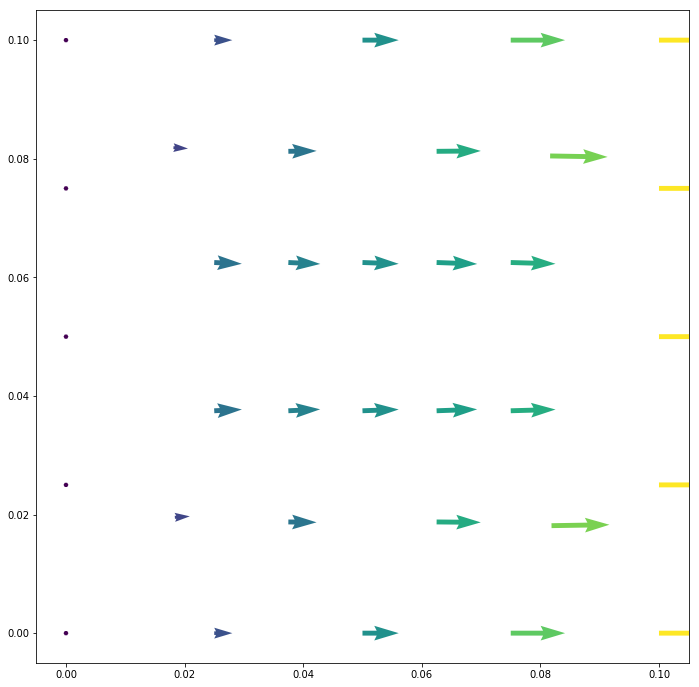

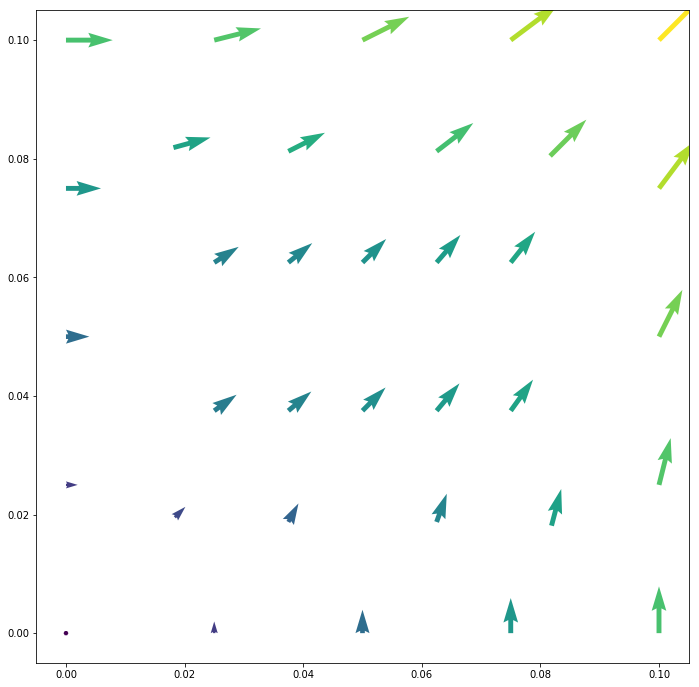

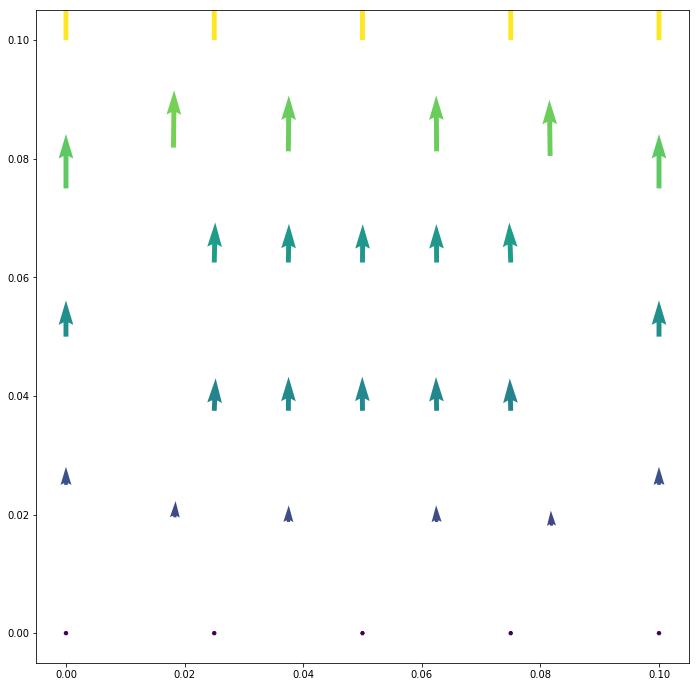

In [99]:
from dolfin import *
import matplotlib.pyplot as plt

def press_bottom(x, on_bound):
    return on_bound and near(x[1], -pressHeight)
 
def press_top(x, on_bound):
    return on_bound and near(x[1], blockHeight + pressHeight)
 
def border_all(x, on_bound):
    return on_bound

class CoefExp(UserExpression):
    def value_shape(s):
        return []
    def eval_cell(s, v, x, c):
        if s.d[c.index] == 0:
            v[0] = s.v1
        else:
            v[0] = s.v2

def Coef(domains, v1, v2):
    W = FunctionSpace(domains.mesh(), "DG", 0)
    C = CoefExp(degree=0)
    C.d = domains
    C.v1 = v1
    C.v2 = v2
    return project(C, W)
    
def epsilon(v):
    return 0.5*(grad(v) + grad(v).T)
 
def sigma(lmd, mu, v):
    return lmd*tr(epsilon(v))*Identity(2)+2*mu*epsilon(v)
            
def problem(name):
    mesh = Mesh("meshes/%s.xml" % name)
    domains = MeshFunction("size_t", mesh, "meshes/%s_domains.xml" % name)
    bounds = MeshFunction("size_t", mesh, 1, 0)
    AutoSubDomain(press_bottom).mark(bounds, 1)
    AutoSubDomain(press_top).mark(bounds, 2)
    
    E   = Coef(domains, E1, E2)
    nu  = Coef(domains, nu1, nu2)
    lmd = nu * E / (1 + nu) / (1 - 2 * nu)
    mu  = E / 2 / (1 + nu)
    
    ds = Measure("ds", subdomain_data=bounds)
    V = VectorFunctionSpace(mesh, "CG", 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    bc = DirichletBC(V, Constant((0, 0)), bounds, 1)
    a = inner(sigma(lmd, mu, u), epsilon(v)) * dx
    L = inner(f, v) * ds(2)
    y = Function(V)
    solve(a == L, y, bc)
    
    File("%s/u.xml" % name) << y
    File("%s/u.pvd" % name) << y
    plt.figure(figsize=(16, 12))
    plot(y)
    return y

def hom_coef(lmd, mu, y, i):
    eps11 =     assemble(epsilon(y)[0, 0]*dx)
    eps12 = 2 * assemble(epsilon(y)[0, 1]*dx)
    eps22 =     assemble(epsilon(y)[1, 1]*dx)
    print("epsilon: ", eps11, eps12, eps22)
    if i == 0:
        epsj = eps11
    elif i == 1:
        epsj = eps12
    else:
        epsj = eps22
    Ej1 = assemble(sigma(lmd, mu, y)[0, 0]*dx)/epsj
    Ej2 = assemble(sigma(lmd, mu, y)[0, 1]*dx)/epsj
    Ej3 = assemble(sigma(lmd, mu, y)[1, 1]*dx)/epsj
    return Ej1, Ej2, Ej3
    
def hom_local(name):
    mesh = Mesh("meshes/%s.xml" % name)
    domains = MeshFunction("size_t", mesh, "meshes/%s_domains.xml" % name)
    
    E   = Coef(domains, E1, E2)
    nu  = Coef(domains, nu1, nu2)
    lmd = nu * E / (1 + nu) / (1 - 2 * nu)
    mu  = E / 2 / (1 + nu)
    
    V = VectorFunctionSpace(mesh, "CG", 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    bcs = [DirichletBC(V, Expression(('x[0]', '0'), degree=1), border_all),
           DirichletBC(V, Expression(('x[1]/2', 'x[0]/2'), degree=1), border_all),
           DirichletBC(V, Expression(('0', 'x[1]'), degree=1), border_all)]

    a = inner(sigma(lmd, mu, u), epsilon(v)) * dx
    L = inner(Constant([0, 0]), v) * ds
    y = Function(V)
    Eh = []
    for i in range(len(bcs)):
        solve(a == L, y, bcs[i])
        File("%s/u%d.xml" % (name, i)) << y
        File("%s/u%d.pvd" % (name, i)) << y
        plt.figure(figsize=(16, 12))
        plot(y)
        Eh.append(hom_coef(lmd, mu, y, i))
    return Eh
   
class ElasticityCoefExp(UserExpression):
    def value_shape(s):
        return [3, 3, 3]
    def eval_cell(s, v, x, c):
        i = s.d[c.index]
        if i == 0:
            v = s.EC0
        elif i == 1:
            v = s.EC1
        else:
            v = s.EC2

def ElasticityCoef(domains, EC0, EC1, EC2):
    C = ElasticityCoefExp(degree=0)
    C.d = domains
    C.EC0 = EC0
    C.EC1 = EC1
    C.EC2 = EC2
    return project(C, W)
    
def hom_coarse(name, Eh):
    mesh = Mesh("meshes/%s.xml" % name)
    domains = MeshFunction("size_t", mesh, "meshes/%s_domains.xml" % name)
    bounds = MeshFunction("size_t", mesh, 1, 0)
    AutoSubDomain(press_bottom).mark(bounds, 1)
    AutoSubDomain(press_top).mark(bounds, 2)
    
    lmd1 = nu1 * E1 / (1 + nu1) / (1 - 2 * nu1)
    mu1  = E1 / 2 / (1 + nu1)
    lmd2 = nu2 * E2 / (1 + nu2) / (1 - 2 * nu2)
    mu2  = E2 / 2 / (1 + nu2)
    
    EC1 = 
    
    E = Expression((('d<1?E11:lmd+2*mu', 'd<1?E21:0',  'd<1?E31:lmd'), 
                                      ('d<1?E12:0',        'd<1?E22:mu', 'd<1?E32:0'), 
                                      ('d<1?E13:lmd',      'd<1?E23:0',  'd<1?E33:lmd+2*mu')), 
                                      degree=0, d=domains, lmd=Constant(lmd), mu=Constant(mu),
                                      E11=E11, E12=E12, E13=E13, E21=E21, E22=E22, E23=E23, E31=E31, E32=E32, E33=E33)

    ds = Measure("ds", subdomain_data=bounds)
    V = VectorFunctionSpace(mesh, "CG", 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    bc = DirichletBC(V, Constant((0, 0)), bounds, 1)
    a = inner(sigma(lmd, mu, u), epsilon(v)) * dx
    L = inner(f, v) * ds(2)
    y = Function(V)
    solve(a == L, y, bc)
    
    File("%s/u.xml" % name) << y
    File("%s/u.pvd" % name) << y
    plt.figure(figsize=(16, 12))
    plot(y)
    return y
    
blockHeight = 0.5
pressHeight = 0.1
E1, E2 = 4e10, 2e11
nu1, nu2 = 0.15, 0.3
f = Constant((0, -1e5))

#u = problem("block")
Eh = hom_local("rve")



